# GNN for AML

This notebook conducts an exploratory data analysis (EDA) on a single dataset from the [IBM Transactions for Anti-Money Laundering (AML) - Kaggle](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml) dataset. The dataset represents transactions with **high incidence (HI) of money laundering**. The goal of this analysis is to understand the distribution of transaction features, compare positive and negative labels, and examine statistical associations between features and money laundering risk.

**Affiliations:** TD Bank, Columbia University  
**Last updated:** 2025-02-11

#### Data Source
- **Source:** [IBM Transactions for Anti-Money Laundering (AML) - Kaggle](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml)
- **HI Dataset:** Transactions with a higher prevalence of money laundering cases.

## Notebook configuration

In [ ]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import ipywidgets as widgets
import os
import sys
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate
from tqdm import trange
from IPython import get_ipython
from IPython.display import display
from time import monotonic
from pprint import pprint
from google.colab import drive

# Project Source Code
src_path = os.path.abspath(os.path.join(os.getcwd(), "../../src"))
sys.path.append(src_path)
from helpers import add_cell_timer

# NN-specific imports
# !pip install torchmetrics
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from sklearn.model_selection import train_test_split
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from torchmetrics.classification import Recall, Accuracy, AUROC, Precision

add_cell_timer()

In [ ]:
content_base = "/content/drive"
data_dir = os.path.join(content_base, "My Drive/Capstone/data")
data_file = os.path.join(data_dir, "HI-Small_Trans.csv")


⏱️ Execution time: 0.0s


In [ ]:
drive.mount(content_base)
files = os.listdir(data_dir)
print("\nData files available:")
pprint(files)

Mounted at /content/drive

Data files available:
['HI-Small_Trans.csv']

⏱️ Execution time: 26.44s


## Load data

In [ ]:
df = pd.read_csv(data_file, parse_dates=["Timestamp"])


⏱️ Execution time: 15.76s


## Data cleaning

#### Rename columns for clarity

In [ ]:
df.rename(
    columns={
        "Timestamp": "timestamp",
        "From Bank": "from_bank",
        "Account": "from_account",
        "To Bank": "to_bank",
        "Account.1": "to_account",
        "Amount Received": "received_amount",
        "Receiving Currency": "received_currency",
        "Amount Paid": "sent_amount",
        "Payment Currency": "sent_currency",
        "Payment Format": "payment_type",
        "Is Laundering": "is_laundering",
    },
    inplace=True,
)


⏱️ Execution time: 0.0s


#### Add columns for time of day, hour of day, and day of week

In [ ]:
# Add columns for time of day, hour of day, and day of week
df["time_of_day"] = df["timestamp"].dt.time
df["hour_of_day"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.day_name()


⏱️ Execution time: 3.64s


#### Check data for missing values and remove duplicates

In [ ]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for duplicate rows
print("\nDuplicate Rows:")
print(df.duplicated().sum())

df.drop_duplicates(inplace=True)


Missing Values:
timestamp            0
from_bank            0
from_account         0
to_bank              0
to_account           0
received_amount      0
received_currency    0
sent_amount          0
sent_currency        0
payment_type         0
is_laundering        0
time_of_day          0
hour_of_day          0
day_of_week          0
dtype: int64

Duplicate Rows:
9

⏱️ Execution time: 19.55s


#### Check that received amount and sent amount are equal

In [ ]:
print(f"N accounts with diff received and sent amount: {sum(df['received_amount'] != df['sent_amount'])}")
not_eq=df[df["received_amount"]!= df["sent_amount"]]
print(f"N accounts with diff received and sent amount & diff currency: {sum(not_eq['received_currency'] != not_eq['sent_currency'])}")

N accounts with diff received and sent amount: 72154
N accounts with diff received and sent amount & diff currency: 72154

⏱️ Execution time: 0.42s


✔ Sent and received amounts are only different when currency change is involved.

#### Check that unique account numbers are not found at different banks

In [ ]:
def count_accounts_across_multiple_banks(df: pd.DataFrame) -> int:
    """Count the number of unique accounts that appear in multiple banks."""

    # Count number of unique banks associated with each 'from_account'
    from_account_counts = df.groupby("from_account")["from_bank"].nunique()
    from_multi_bank_accounts = from_account_counts[from_account_counts > 1].index

    # Count number of unique banks associated with each 'to_account'
    to_account_counts = df.groupby("to_account")["to_bank"].nunique()
    to_multi_bank_accounts = to_account_counts[to_account_counts > 1].index

    # Combine both lists (some accounts might be senders in some transactions, receivers in others)
    unique_accounts_across_banks = set(from_multi_bank_accounts).union(set(to_multi_bank_accounts))

    return len(unique_accounts_across_banks)

# Compute the number of accounts appearing at multiple banks
num_accounts_multiple_banks = count_accounts_across_multiple_banks(df)

print(f"Number of accounts associated with multiple banks: {num_accounts_multiple_banks}")


Number of accounts associated with multiple banks: 8

⏱️ Execution time: 3.81s


We do need to combine bank and account number then:

In [ ]:
df['from_account_bank'] = df['from_bank'].astype(str) + '_' + df['from_account'].astype(str)
df['to_account_bank'] = df['to_bank'].astype(str) + '_' + df['to_account'].astype(str)


⏱️ Execution time: 5.45s


## Data description

Quick glance at some observations in our data:

In [ ]:
df.head()

,timestamp,from_bank,from_account,to_bank,to_account,received_amount,received_currency,sent_amount,sent_currency,payment_type,is_laundering,time_of_day,hour_of_day,day_of_week,from_account_bank,to_account_bank
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,00:20:00,0,Thursday,10_8000EBD30,10_8000EBD30
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,00:20:00,0,Thursday,3208_8000F4580,1_8000F5340
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,00:00:00,0,Thursday,3209_8000F4670,3209_8000F4670
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,00:02:00,0,Thursday,12_8000F5030,12_8000F5030
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,00:06:00,0,Thursday,10_8000F5200,10_8000F5200



⏱️ Execution time: 0.02s


### Data imbalance: entire dataset

#### Class balance
Next, we will check the proportion of classes which are money laundering (`is_laundering == 1`)

In [ ]:
print(f"N obs: {len(df)}")
print(f"N laundering: {len(df[df['is_laundering']==1])}")
print(f"Percent laundering cases: {round(len(df[df['is_laundering']==1])/len(df)*100,5)}%")

N obs: 5078336
N laundering: 5177
Percent laundering cases: 0.10194%

⏱️ Execution time: 0.04s


We have an extremely imbalanced dataset even when using the "High-Illicit" sample.

#### Feature balance, licit vs. illicit

In [ ]:
import matplotlib.pyplot as plt

def plot_column_imbalance(df: pd.DataFrame, column: str, label: str) -> None:
    if pd.api.types.is_numeric_dtype(df[column]):
        # Custom bins for numerical data
        df["binned"] = pd.cut(
            df[column],
            bins=[0, 10, 100, 1000, 10000, np.inf],
            include_lowest=True,
        )
        bin_labels = {
            interval: f"{int(interval.left)} - {int(interval.right) if interval.right != np.inf else '∞'}"
            for interval in df["binned"].cat.categories
        }
        df["binned"] = df["binned"].map(bin_labels)
        all_types = sorted(
            bin_labels.values(), key=lambda x: int(x.split(" - ")[0])
        )
        data_column = "binned"
    else:
        all_types = df[column].unique()
        data_column = column

    # Separate licit and illicit transactions
    df_licit = df[df["is_laundering"] == 0]
    df_illicit = df[df["is_laundering"] == 1]

    # Compute proportions relative to each category's total count
    proportion_licit = (df_licit[data_column].value_counts() / len(df_licit)) * 100
    proportion_licit = proportion_licit.reindex(all_types, fill_value=0)

    proportion_illicit = (df_illicit[data_column].value_counts() / len(df_illicit)) * 100
    proportion_illicit = proportion_illicit.reindex(all_types, fill_value=0)

    # Plot
    fig, ax = plt.subplots(figsize=(7, 4))
    x_pos = np.arange(len(all_types))

    ax.bar(x_pos - 0.2, proportion_licit, width=0.4, color="#76c7c0", label="Licit")
    ax.bar(x_pos + 0.2, proportion_illicit, width=0.4, color="#f4a261", label="Illicit")
    ax.axhline(50, linestyle="--", color="gray", linewidth=1)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(all_types, rotation=45, ha="right")
    ax.set_ylabel("Proportion (%)")
    ax.set_title(f"{label}, Licit vs. Illicit")
    ax.legend(loc="upper right")
    plt.show()

# Define column mapping
column_mapping_imbalance = {
    "Payment Type": "payment_type",
    "Sent Currency": "sent_currency",
    "Received Currency": "received_currency",
    "Sent Amount": "sent_amount",
    "Received Amount": "received_amount",
}

# Dropdown widget
dropdown_imbalance = widgets.Dropdown(
    options=column_mapping_imbalance.keys(),
    description="Column:",
    style={"description_width": "initial"},
)

# Update function
def update_plot(column_label: str) -> None:
    column = column_mapping_imbalance[column_label]
    plot_column_imbalance(df, column, column_label)

# Display interactive widget
interactive_plot = widgets.interactive(update_plot, column_label=dropdown_imbalance)
display(interactive_plot)

interactive(children=(Dropdown(description='Column:', options=('Payment Type', 'Sent Currency', 'Received Curr…


⏱️ Execution time: 1.91s


## Splitting data into train and test sets
- **Nodes:** Accounts  
- **Edges:** Transactions  

Since we predict transactions (edges), the split should be edge-based:  
- **Edge-based split:** Train on a subset of transactions and test on another. The same accounts (nodes) may appear in both sets, but individual transactions are split.  
- **Temporal split (preferred):** Train on past transactions to predict future ones. Prevents data leakage and aligns with real-world AML scenarios.  
- **Node-based split (avoid if possible):** Ensures test accounts are unseen during training but requires a disjoint graph, making it impractical unless testing generalization to new nodes.  

#### Learning Approaches  
- **Transductive:** Train on nodes/edges appearing in both sets, but test edge labels remain hidden.  
- **Inductive:** Train on a subset of edges without accessing test edge features or their neighboring nodes.  

**Takeaway:** We'll use a temporal, inductive edge-based split—training on past transactions and testing on future ones.  

#### Considerations  
- **Label Imbalance:** Shifts in licit/illicit ratios can affect thresholds.  
- **Distribution Shift:** Feature distributions may change over time, impacting performance.  
- **Unexpected Values:** New categories or missing data in test sets can cause issues.  
- **Overfitting Clues:** Large statistical differences suggest model over-tuning.  

#### Validation Checks  
- **Stats & Visuals:** Compare means, plot histograms.  
- **Stat Tests:** Use KS test or Chi-square for shifts.  
- **Dimensionality Reduction:** t-SNE or PCA to detect clustering changes.  

**Base case:** 80/20 split.  



### Label imbalance with 80/20 split

In [ ]:
df = df.sort_values(by="timestamp")

# Split the data into 80/20 train-test based on time
split_index = int(0.8 * len(df))
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Calculate percentages of licit and illicit transactions for the train set
train_licit_percentage = (train_df['is_laundering'] == 0).mean() * 100
train_illicit_percentage = (train_df['is_laundering'] == 1).mean() * 100

# Calculate percentages of licit and illicit transactions for the test set
test_licit_percentage = (test_df['is_laundering'] == 0).mean() * 100
test_illicit_percentage = (test_df['is_laundering'] == 1).mean() * 100

# Print the results
print("Train set (80%):")
print(f"Licit transactions: {train_licit_percentage:.2f}%")
print(f"Illicit transactions: {train_illicit_percentage:.2f}%")

print("\nTest set (20%):")
print(f"Licit transactions: {test_licit_percentage:.2f}%")
print(f"Illicit transactions: {test_illicit_percentage:.2f}%")


Train set (80%):
Licit transactions: 99.92%
Illicit transactions: 0.08%

Test set (20%):
Licit transactions: 99.82%
Illicit transactions: 0.18%

⏱️ Execution time: 1.97s


Interestingly, the test set has a much higher proportion of illicit transactions (approx. double that of the train set). This may limit the generalizability of the model training set to the test, which may potentially impact model performance.

This makes a bit of sense with the way that the data were generated. They needed to have time to build up fraud cycles, so the majority of illicit transactions occur later in the dataset.

In [ ]:
df = df.sort_values(by="timestamp")

# Split the data into 80/20 train-test based on time
split_index1 = int(0.9 * len(df))
train_df = df.iloc[:split_index1]
test_df = df.iloc[split_index1:]

# Calculate percentages of licit and illicit transactions for the train set
train_licit_percentage = (train_df['is_laundering'] == 0).mean() * 100
train_illicit_percentage = (train_df['is_laundering'] == 1).mean() * 100

# Calculate percentages of licit and illicit transactions for the test set
test_licit_percentage = (test_df['is_laundering'] == 0).mean() * 100
test_illicit_percentage = (test_df['is_laundering'] == 1).mean() * 100

# Print the results
print("Train set (80%):")
print(f"Licit transactions: {train_licit_percentage:.2f}%")
print(f"Illicit transactions: {train_illicit_percentage:.2f}%")

print("\nTest set (20%):")
print(f"Licit transactions: {test_licit_percentage:.2f}%")
print(f"Illicit transactions: {test_illicit_percentage:.2f}%")

Train set (80%):
Licit transactions: 99.92%
Illicit transactions: 0.08%

Test set (20%):
Licit transactions: 99.73%
Illicit transactions: 0.27%

⏱️ Execution time: 2.18s


### Differences in timespan

In [ ]:
# Calculate the timestamp corresponding to the 80% split
df = df.sort_values(by="timestamp")
print(f"First record: {df.iloc[0]['timestamp']}")
print(f"Last record: {df.iloc[-1]['timestamp']}")
split_index = int(0.8 * len(df))
split_timestamp = df.iloc[split_index]["timestamp"]
print(f"\nTime of 80/20 split: {split_timestamp}")

First record: 2022-09-01 00:00:00
Last record: 2022-09-18 16:18:00

Time of 80/20 split: 2022-09-08 16:12:00

⏱️ Execution time: 1.56s


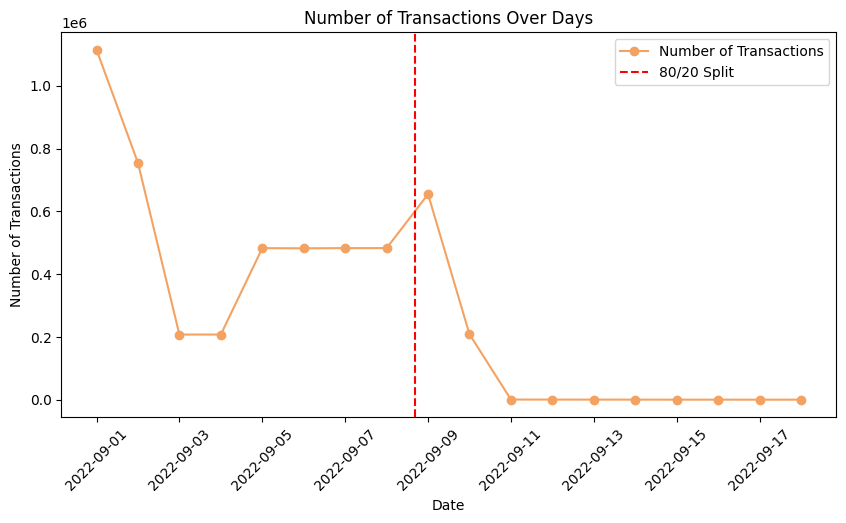


⏱️ Execution time: 2.0s


In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore")

def plot_number_of_transactions_by_day(df: pd.DataFrame, timestamp_col: str) -> None:

    # Group by day (extract only the date part)
    df['date'] = df[timestamp_col].dt.date
    transactions_over_day = df.groupby('date').size()

    # Plot the number of transactions over days
    fig, ax = plt.subplots(figsize=(10, 5))
    transactions_over_day.plot(label="Number of Transactions", color='#f4a261', marker='o', ax=ax)
    ax.axvline(x=split_timestamp, color='red', linestyle='--', label="80/20 Split")
    ax.set_title("Number of Transactions Over Days")
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Transactions")
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

plot_number_of_transactions_by_day(df, 'timestamp')

The dataset we are working with has a little over two weeks of transactions. The red line above indicates where 80% of the total number of transactions has occurred. Interestingly, the first 80% of transactions are clustered in a relatively short timespan of approximately 8 or 9 days, where as the latter 20% spans over equal time (i.e. is much sparser). Once again, we may worry about generalizability given the train data is a bit different from the test data.

### Other features

In [ ]:
warnings.filterwarnings("ignore") # Suppress warnings

def plot_imbalance_comparison(train_df: pd.DataFrame, test_df: pd.DataFrame, column: str, label: str) -> None:
    """Compare feature distribution imbalance between train and test sets."""

    if pd.api.types.is_numeric_dtype(train_df[column]):
      if column == "hour_of_day":  # Special case for time-based data
          bins = [0, 6, 12, 18, 24]  # Night, Morning, Afternoon, Evening
          labels = ["Night (0-6)", "Morning (6-12)", "Afternoon (12-18)", "Evening (18-24)"]
          train_df["binned"] = pd.cut(train_df[column], bins=bins, labels=labels, include_lowest=True)
          test_df["binned"] = pd.cut(test_df[column], bins=bins, labels=labels, include_lowest=True)
          all_types = labels
      else:
        # Define custom bins for numerical data
        bins = [0, 10, 100, 1000, 10000, np.inf]
        train_df["binned"] = pd.cut(train_df[column], bins=bins, include_lowest=True)
        test_df["binned"] = pd.cut(test_df[column], bins=bins, include_lowest=True)

        # Create labels
        bin_labels = {
            interval: f"{int(interval.left)} - {int(interval.right) if interval.right != np.inf else '∞'}"
            for interval in train_df["binned"].cat.categories
        }

        train_df["binned"] = train_df["binned"].map(bin_labels)
        test_df["binned"] = test_df["binned"].map(bin_labels)
        all_types = sorted(bin_labels.values(), key=lambda x: int(x.split(" - ")[0]))

      data_column = "binned"
    elif column == "day_of_week":
        all_types = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        data_column = column
    else:
        all_types = sorted(set(train_df[column].unique()).union(set(test_df[column].unique())))
        data_column = column

    # Compute proportions for train and test sets
    proportion_train = (train_df[data_column].value_counts() / len(train_df)) * 100
    proportion_train = proportion_train.reindex(all_types, fill_value=0)

    proportion_test = (test_df[data_column].value_counts() / len(test_df)) * 100
    proportion_test = proportion_test.reindex(all_types, fill_value=0)

    # Plot
    fig, ax = plt.subplots(figsize=(7, 4))
    x_pos = np.arange(len(all_types))

    ax.bar(x_pos - 0.2, proportion_train, width=0.4, color="#76c7c0", label="Train")
    ax.bar(x_pos + 0.2, proportion_test, width=0.4, color="#f4a261", label="Test")

    ax.set_xticks(x_pos)
    ax.set_xticklabels(all_types, rotation=45, ha="right")
    ax.set_ylabel("Proportion (%)")
    ax.set_title(f"{label} Distribution: Train vs. Test")
    ax.legend(loc="upper right")
    plt.show()

# Define column mapping
column_mapping_imbalance = {
    "Payment Type": "payment_type",
    "Sent Currency": "sent_currency",
    "Received Currency": "received_currency",
    "Sent Amount": "sent_amount",
    "Received Amount": "received_amount",
    "Hour of Day": "hour_of_day",
    "Day of Week": "day_of_week"
}

# Dropdown widget
dropdown_imbalance = widgets.Dropdown(
    options=column_mapping_imbalance.keys(),
    description="Column:",
    style={"description_width": "initial"},
)

def update_plot(column_label: str) -> None:
    column = column_mapping_imbalance[column_label]
    plot_imbalance_comparison(train_df, test_df, column, column_label)

# Create and display interactive widget
interactive_plot = widgets.interactive(update_plot, column_label=dropdown_imbalance)
display(interactive_plot)


interactive(children=(Dropdown(description='Column:', options=('Payment Type', 'Sent Currency', 'Received Curr…


⏱️ Execution time: 0.86s


#### Compare train and test data based on licit and illicit feature distributions

In [ ]:
def plot_column_imbalance(train_df: pd.DataFrame, test_df: pd.DataFrame, column: str, label: str) -> None:
    """Compare feature distribution imbalance between train and test sets for licit and illicit transactions separately."""

    if pd.api.types.is_numeric_dtype(train_df[column]):
        # Define bins for numerical features
        if column == "hour_of_day":  # Special case for time-based data
          # bins = [0, 6, 12, 18, 24]  # Night, Morning, Afternoon, Evening
          # labels = ["Night (0-6)", "Morning (6-12)", "Afternoon (12-18)", "Evening (18-24)"]
          # train_df["binned"] = pd.cut(train_df[column], bins=bins, labels=labels, include_lowest=True)
          # test_df["binned"] = pd.cut(test_df[column], bins=bins, labels=labels, include_lowest=True)
          all_types = list(range(24))
          data_column = column
        else:
          bins = [0, 10, 100, 1000, 10000, np.inf]
          train_df["binned"] = pd.cut(train_df[column], bins=bins, include_lowest=True)
          test_df["binned"] = pd.cut(test_df[column], bins=bins, include_lowest=True)

          # Label bins consistently
          bin_labels = {
              interval: f"{int(interval.left)} - {int(interval.right) if interval.right != np.inf else '∞'}"
              for interval in train_df["binned"].cat.categories
          }

          train_df["binned"] = train_df["binned"].map(bin_labels)
          test_df["binned"] = test_df["binned"].map(bin_labels)
          all_types = sorted(bin_labels.values(), key=lambda x: int(x.split(" - ")[0]))

          data_column = "binned"
    elif column == "day_of_week":
        all_types = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        data_column = column
    else:
        all_types = sorted(set(train_df[column].unique()).union(set(test_df[column].unique())))
        data_column = column

    # Split train & test into licit and illicit
    train_licit = train_df[train_df["is_laundering"] == 0]
    train_illicit = train_df[train_df["is_laundering"] == 1]
    test_licit = test_df[test_df["is_laundering"] == 0]
    test_illicit = test_df[test_df["is_laundering"] == 1]

    # Compute proportions for licit transactions
    proportion_train_licit = (train_licit[data_column].value_counts() / len(train_licit)) * 100
    proportion_train_licit = proportion_train_licit.reindex(all_types, fill_value=0)

    proportion_test_licit = (test_licit[data_column].value_counts() / len(test_licit)) * 100
    proportion_test_licit = proportion_test_licit.reindex(all_types, fill_value=0)

    # Compute proportions for illicit transactions
    proportion_train_illicit = (train_illicit[data_column].value_counts() / len(train_illicit)) * 100
    proportion_train_illicit = proportion_train_illicit.reindex(all_types, fill_value=0)

    proportion_test_illicit = (test_illicit[data_column].value_counts() / len(test_illicit)) * 100
    proportion_test_illicit = proportion_test_illicit.reindex(all_types, fill_value=0)

    # Normalize distributions
    total_train = proportion_train_licit + proportion_train_illicit
    illicit_train_normalized = (proportion_train_illicit / total_train) * 100
    licit_train_normalized = (proportion_train_licit / total_train) * 100

    total_test = proportion_test_illicit + proportion_test_licit
    illicit_test_normalized = (proportion_test_illicit / total_test) * 100
    licit_test_normalized = (proportion_test_licit / total_test) * 100

    # Plot side-by-side horizontal bar charts
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    y_pos = np.arange(len(all_types))

    # Plot Train transactions
    axes[0].barh(y_pos, licit_train_normalized, color="#76c7c0", label="Licit")
    axes[0].barh(y_pos, illicit_train_normalized, left=licit_train_normalized, color="#f4a261", label="Illicit")
    axes[0].axvline(50, linestyle="--", color="gray", linewidth=1)
    axes[0].set_yticks(y_pos)
    axes[0].set_yticklabels(all_types)
    axes[0].set_xlabel("Proportion (%)")
    axes[0].set_title(f"{label} - Train Transactions")
    axes[0].legend(loc="upper left")

    # Plot Illicit transactions
    axes[1].barh(y_pos, licit_test_normalized, color="#76c7c0", label="Licit")
    axes[1].barh(y_pos, illicit_test_normalized, left=licit_test_normalized, color="#f4a261", label="Illicit")
    axes[1].axvline(50, linestyle="--", color="gray", linewidth=1)
    axes[1].set_yticks(y_pos)
    axes[1].set_xlabel("Proportion (%)")
    axes[1].set_title(f"{label} - Test Transactions")
    axes[1].legend(loc="upper left")

    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Dropdown widget for interactive selection
column_mapping_imbalance = {
    "Payment Type": "payment_type",
    "Sent Currency": "sent_currency",
    "Received Currency": "received_currency",
    "Sent Amount": "sent_amount",
    "Received Amount": "received_amount",
    "Hour of Day": "hour_of_day",
    "Day of Week": "day_of_week"
}

dropdown_imbalance = widgets.Dropdown(
    options=column_mapping_imbalance.keys(),
    description="Column:",
    style={"description_width": "initial"},
)

def update_plot(column_label: str) -> None:
    column = column_mapping_imbalance[column_label]
    plot_column_imbalance(train_df, test_df, column, column_label)

# Display interactive plot
interactive_plot = widgets.interactive(update_plot, column_label=dropdown_imbalance)
display(interactive_plot)



interactive(children=(Dropdown(description='Column:', options=('Payment Type', 'Sent Currency', 'Received Curr…


⏱️ Execution time: 2.85s


## Looking at a different time-split

In [ ]:
def plot_data_balance(df: pd.DataFrame, timestamp_col: str,cumulative: bool) -> None:
    # Sort by timestamp
    df = df.sort_values(by=timestamp_col)

    # Compute class proportions over time
    df['date'] = df[timestamp_col].dt.date

    if cumulative:
        cumulative_counts = df.groupby('date')['is_laundering'].value_counts().unstack().cumsum(axis=0)
        # Normalize cumulative counts to get cumulative proportions
        cumulative_proportion_over_time = cumulative_counts.div(cumulative_counts.sum(axis=1), axis=0) * 100
        # Plot Line Chart
        fig, ax = plt.subplots(figsize=(10, 5))
        cumulative_proportion_over_time[1].plot(label='Illicit', color='#f4a261', marker='o', ax=ax)
        ax.set_title("Cumulative Proportion of Illicit Transactions Over Time")
    else:
        counts = df.groupby('date')['is_laundering'].value_counts().unstack()
        # Normalize cumulative counts to get proportions
        proportion_over_time = counts.div(counts.sum(axis=1), axis=0) * 100
        # Plot Line Chart
        fig, ax = plt.subplots(figsize=(10, 5))
        proportion_over_time[1].plot(label='Illicit', color='#f4a261', marker='o', ax=ax)
        ax.set_title("Proportion of Illicit Transactions Over Time")

    ax.set_xlabel("Date")
    ax.set_ylabel("Proportion (%)")
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

cumulative_dropdown = widgets.Checkbox(
    value=True,
    description='Cumulative',
    disabled=False
)

def update_plot(cumulative):
    plot_data_balance(df, 'timestamp', cumulative)

# Display dropdowns
widgets.interactive(update_plot, cumulative=cumulative_dropdown)

interactive(children=(Checkbox(value=True, description='Cumulative'), Output()), _dom_classes=('widget-interac…


⏱️ Execution time: 4.02s


### Label imbalance with 70/15/15 split

In [ ]:
train_idx = int(0.7 * len(df))
val_idx = int(0.85 * len(df))

def split_train_val_test(df: pd.DataFrame) -> None:
    """Split the dataset into 70% train, 15% validation, and 15% test based on timestamp,
    and print the proportion of licit and illicit transactions in each split."""

    # Sort by timestamp to ensure temporal split
    df = df.sort_values(by="timestamp")

    # Split the dataset
    train_df = df.iloc[:train_idx]
    val_df = df.iloc[train_idx:val_idx]
    test_df = df.iloc[val_idx:]

    # Calculate percentages of licit and illicit transactions in each split
    def compute_percentages(sub_df):
        licit_percentage = (sub_df["is_laundering"] == 0).mean() * 100
        illicit_percentage = (sub_df["is_laundering"] == 1).mean() * 100
        return licit_percentage, illicit_percentage

    train_licit, train_illicit = compute_percentages(train_df)
    val_licit, val_illicit = compute_percentages(val_df)
    test_licit, test_illicit = compute_percentages(test_df)

    # Print results
    print("Train set (70%):")
    print(f"Licit transactions: {train_licit:.2f}%")
    print(f"Illicit transactions: {train_illicit:.2f}%")

    print("\nValidation set (15%):")
    print(f"Licit transactions: {val_licit:.2f}%")
    print(f"Illicit transactions: {val_illicit:.2f}%")

    print("\nTest set (15%):")
    print(f"Licit transactions: {test_licit:.2f}%")
    print(f"Illicit transactions: {test_illicit:.2f}%")

    return train_df, val_df, test_df

train_df, val_df, test_df = split_train_val_test(df)

Train set (70%):
Licit transactions: 99.92%
Illicit transactions: 0.08%

Validation set (15%):
Licit transactions: 99.90%
Illicit transactions: 0.10%

Test set (15%):
Licit transactions: 99.80%
Illicit transactions: 0.20%

⏱️ Execution time: 1.48s


#### Differences in timespan

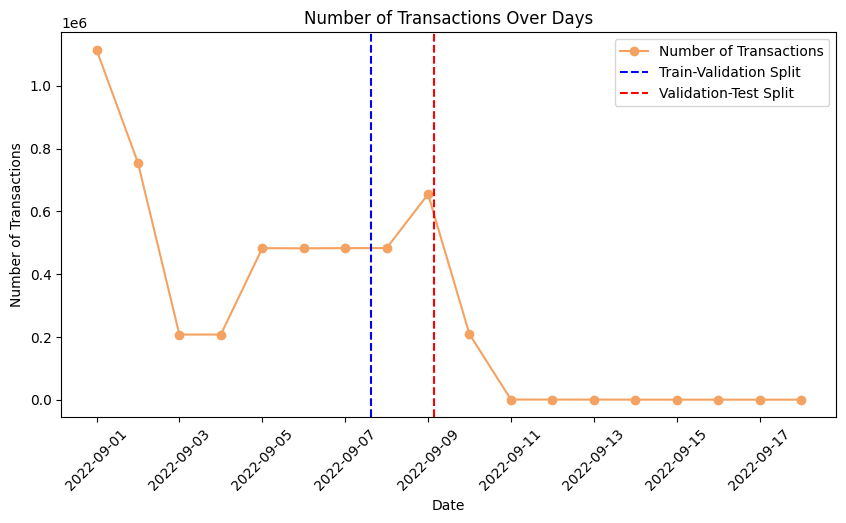


⏱️ Execution time: 2.21s


In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore")
val_split_timestamp = df.iloc[val_idx]['timestamp']
train_split_timestamp = df.iloc[train_idx]['timestamp']

def plot_number_of_transactions_by_day(df: pd.DataFrame, timestamp_col: str) -> None:
    # Convert timestamp to datetime format (if it's not already)
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    # Group by day (extract only the date part)
    df['date'] = df[timestamp_col].dt.date
    transactions_over_day = df.groupby('date').size()

    # Plot the number of transactions over days
    fig, ax = plt.subplots(figsize=(10, 5))
    transactions_over_day.plot(label="Number of Transactions", color='#f4a261', marker='o', ax=ax)
    ax.axvline(x=train_split_timestamp, color='blue', linestyle='--', label="Train-Validation Split")
    ax.axvline(x=val_split_timestamp, color='red', linestyle='--', label="Validation-Test Split")
    ax.set_title("Number of Transactions Over Days")
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Transactions")
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

plot_number_of_transactions_by_day(df, 'timestamp')

# Feature engineering

### 1. Transform timestamp with min-max normalization
Timestamps capture the timing of transactions, which is crucial in AML.
Min-max normalization scales timestamps between 0 and 1, preserving their relative ordering while making them comparable across different time ranges.
GNNs and ML models work better with normalized features rather than raw timestamps (which can be large integers).

**Future considerations:**
* may also log time or z-score transform it
* lose some information about distance between timestamps, especially since test data is over a longer period of time ...
* Further, with transformation we lose other pertinent information such as day of week and hour of day
* Idea: include multiple attributes:
  - Log/zscore transformed timestamp (keeps global time progress)
  - Day of week
  - Hour of day

### 2. Create unique id for each account by combining bank code and account number
Some accounts may have the same acct number but exist at different banks. Merging bank code + account number ensures that each node in the transaction graph is uniquely identified.

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# import currency

np.random.seed(42)

def df_label_encoder(df, columns):
      le = preprocessing.LabelEncoder()
      for i in columns:
          df[i] = le.fit_transform(df[i].astype(str))
      return df

def preprocess(df):
  """
  Preprocesses the entire dataframe, including node mappings, label encoding,
  and time processing which is independent of data split.
  """
  ## Create unique account - ID mapping ##
  # Get unique account-bank combos (a couple of acct numbers found at multiple banks)
  df['from_account_id'] = df['from_bank'].astype(str) + '_' + df['from_account'].astype(str)
  df['to_account_id'] = df['to_bank'].astype(str) + '_' + df['to_account'].astype(str)

  # Get list of unique account ids
  df = df.reset_index(drop=True)
  from_nodes = df["from_account_id"].drop_duplicates().reset_index(drop=True)
  to_nodes = df["to_account_id"].drop_duplicates().reset_index(drop=True)
  all_nodes = pd.concat([from_nodes, to_nodes]).drop_duplicates().reset_index(drop=True)

  # Map node identifiers to integer indices
  node_mapping = {node: idx for idx, node in enumerate(all_nodes)}
  df["from_account_idx"] = df["from_account_id"].map(node_mapping)
  df["to_account_idx"] = df["to_account_id"].map(node_mapping)

  ## Label encode categorical vars ##
  # Use label encoding and let model learn (instead of one-hot embeddings)
  df = df_label_encoder(df, ["payment_type", "sent_currency", "received_currency", "from_bank", "to_bank"])

  ## Currency conversion ## (not using for now, just looking at temporal feats)
  # usd_conversion = currency.get_usd_conversion(df)
  # df['Amount Paid (USD)'] = df.apply(lambda row: row['Amount Paid'] * usd_conversion.get(row['Payment Currency'], 1), axis=1)
  # df['Amount Received (USD)'] = df.apply(lambda row: row['Amount Received'] * usd_conversion.get(row['Receiving Currency'], 1), axis=1)

  ## Time transformations ##
  # Extract items from timestamp
  df["time_of_day"] = df["timestamp"].dt.time
  df["hour_of_day"] = df["timestamp"].dt.hour
  df["day_of_week"] = df["timestamp"].dt.weekday # 0=Monday,...,6=Sunday
  df["seconds_since_midnight"] = (
    df["timestamp"].dt.hour * 3600 +  # Convert hours to seconds
    df["timestamp"].dt.minute * 60 +  # Convert minutes to seconds
    df["timestamp"].dt.second         # Keep seconds
  )

  # Transform timestamp to raw int unix
  df["timestamp_int"] = df["timestamp"].astype(int) / 10**9

  # Apply cyclical encoding
  df["day_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
  df["day_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)
  df["time_of_day_sin"] = np.sin(2 * np.pi * df["seconds_since_midnight"] / 86400)
  df["time_of_day_cos"] = np.cos(2 * np.pi * df["seconds_since_midnight"] / 86400)

  # Create binary weekend indicator
  df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

  df.drop(columns=["from_account","to_account"], inplace=True)

  return df

def normalize(df, scaler_time, scaler_amount):
    """
    Normalizes timestamp and transaction amounts using given scalers.
    """
    # Sort transactions by time
    df = df.sort_values(by=["from_account_idx", "timestamp"])

    # Apply scaling
    df["timestamp_scaled"] = scaler_time.transform(df[["timestamp_int"]])
    # df[["sent_amount_scaled", "received_amount_scaled"]] = scaler_amount.transform(df[["sent_amount", "received_amount"]])

    # Compute time difference between transactions per account and convert to seconds
    df["time_diff_from_acct"] = df.groupby("from_account_idx")["timestamp"].diff().dt.total_seconds().fillna(0)
    df["time_diff_to_acct"] = df.groupby("to_account_idx")["timestamp"].diff().dt.total_seconds().fillna(0)

    return df


⏱️ Execution time: 0.75s


Random stratified split:

In [ ]:
# Preprocess entire df
df_original = df.copy()
df_transformed = preprocess(df_original)

# Split train and test data using random stratification
train_df_rs, test_df_rs = train_test_split(
    df_transformed,
    test_size=0.2,
    stratify=df_transformed["is_laundering"],
    random_state=42
)

### Random stratified
### Scaling the data
# Choose a scaler (MinMax or StandardScaler)
scaler1 = MinMaxScaler() # Choose a scaler (MinMax or StandardScaler)
scaler2 = StandardScaler()
# Fit scalar to training data before preprocessing
# Fit only on training data, then transform train/val/test separately
# This makes scaling consistent (not confusing model)
scaler1.fit(train_df_rs[["timestamp_int"]])
scaler2.fit(train_df_rs[["sent_amount", "received_amount"]])  # Fit only on training data
### Preprocess
train_df_rs, test_df_rs = normalize(train_df_rs, scaler1, scaler2), normalize(test_df_rs, scaler1, scaler2)


⏱️ Execution time: 43.72s


If doing temporal split:

In [ ]:
# ### Temporal
# # Preprocess entire df
# df_original = df.copy()
# df_transformed = preprocess(df_original)
# df_transformed = df_transformed.sort_values(by=["timestamp"])
# train_idx = int(0.8 * len(df))
# train_df_t, test_df_t = df_transformed.iloc[:train_idx], df_transformed.iloc[train_idx:]
# scalar3 = MinMaxScaler()
# scalar4 = StandardScaler()
# scalar3.fit(train_df_t[["timestamp_int"]])
# scalar4.fit(train_df_t[["sent_amount", "received_amount"]])
# # Preprocess
# train_df_t, test_df_t = normalize(train_df_t, scalar3, scalar4), normalize(test_df_t, scalar3, scalar4)

# Test different temporal features

## RFC (manual)

#### Function to run random forests

In [ ]:
from re import X
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Function to train and evaluate a model on a specific feature set
def train_evaluate(results, X_train, X_test, y_train, y_test, model_name, thresholds, class_weights):
    model = RandomForestClassifier(n_estimators=20, random_state=42, class_weight=class_weights)
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_test)[:, 1]

    for t in thresholds:
      y_pred = (y_proba > t).astype(int)
      acc = accuracy_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred, average="binary")
      precision = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      results.append({"Class Weights": f"{class_weights}", "Threshold": t, "Feature Set": model_name, "Accuracy": acc, "F1 Score": f1, "Precision":precision, "Recall": recall})

    return model, results


⏱️ Execution time: 0.0s


#### timestamp_int vs. timestamp_scaled

In [ ]:
original_feats = ["timestamp_int", "sent_currency", "received_currency", "sent_amount", "received_amount", "payment_type"]
transformed_feats = ["timestamp_scaled", "sent_currency", "received_currency", "sent_amount", "received_amount", "payment_type"]
X_train_orig, y_train, X_test_orig, y_test = train_df_rs[original_feats], train_df_rs["is_laundering"], test_df_rs[original_feats], test_df_rs["is_laundering"]
X_train_trans, _, X_test_trans, _ = train_df_rs[transformed_feats], test_df_rs[transformed_feats], test_df_rs[transformed_feats], test_df_rs["is_laundering"]

results = []
thresholds = [0.5, 0.3, 0.1]
class_weights_options = ["balanced", {0: 1, 1: 2}, {0: 1, 1: 5}]

# Timestamp vs timestamp_scaled, weights = balanced
model1, results = train_evaluate(results, X_train_orig, X_test_orig, y_train, y_test, "timestamp_int", thresholds, class_weights_options[0])
model2, results = train_evaluate(results, X_train_trans, X_test_trans, y_train, y_test, "timestamp_scaled", thresholds, class_weights_options[0])

# Timestamp vs timestamp_scaled, weights = {0:1, 1:2}
model3, results = train_evaluate(results, X_train_orig, X_test_orig, y_train, y_test, "timestamp_int", thresholds, class_weights_options[1])
model4, results = train_evaluate(results, X_train_trans, X_test_trans, y_train, y_test, "timestamp_scaled", thresholds, class_weights_options[1])

# Timestamp vs timestamp_scaled, weights = {0:1, 1:5}
model5, results = train_evaluate(results, X_train_orig, X_test_orig, y_train, y_test, "timestamp_int", thresholds, class_weights_options[2])
model6, results = train_evaluate(results, X_train_trans, X_test_trans, y_train, y_test, "timestamp_scaled", thresholds, class_weights_options[2])

results_timestamp = results.copy()


⏱️ Execution time: 430.52s


#### time_of_day vs. time_of_day_sin, time_of_day_cos

In [ ]:
original_feats = ["seconds_since_midnight", "timestamp_scaled", "sent_currency", "received_currency", "sent_amount", "received_amount", "payment_type"]
transformed_feats = ["time_of_day_sin", "time_of_day_cos", "timestamp_scaled", "sent_currency", "received_currency", "sent_amount", "received_amount", "payment_type"]
X_train_orig, y_train, X_test_orig, y_test = train_df_rs[original_feats], train_df_rs["is_laundering"], test_df_rs[original_feats], test_df_rs["is_laundering"]
X_train_trans, _, X_test_trans, _ = train_df_rs[transformed_feats], test_df_rs[transformed_feats], test_df_rs[transformed_feats], test_df_rs["is_laundering"]

results = []
thresholds = [0.5, 0.3, 0.1]
class_weights_options = ["balanced", {0: 1, 1: 2}, {0: 1, 1: 5}]

# Time of day vs time of day cyclical, weights = balanced
_, results = train_evaluate(results, X_train_orig, X_test_orig, y_train, y_test, "time_of_day", thresholds, class_weights_options[0])
_, results = train_evaluate(results, X_train_trans, X_test_trans, y_train, y_test, "time_of_day_cos, time_of_day_sin", thresholds, class_weights_options[0])

# Time of day vs time of day cyclical, weights = {0:1, 1:2}
_, results = train_evaluate(results, X_train_orig, X_test_orig, y_train, y_test, "time_of_day", thresholds, class_weights_options[2])
_, results = train_evaluate(results, X_train_trans, X_test_trans, y_train, y_test, "time_of_day_cos, time_of_day_sin", thresholds, class_weights_options[1])

# Time of day vs time of day cyclical, weights = {0:1, 1:5}
_, results = train_evaluate(results, X_train_orig, X_test_orig, y_train, y_test, "time_of_day", thresholds, class_weights_options[1])
_, results = train_evaluate(results, X_train_trans, X_test_trans, y_train, y_test, "time_of_day_cos, time_of_day_sin", thresholds, class_weights_options[2])

pd.DataFrame(results)


⏱️ Execution time: 1256.24s


## GridSearchCV
Now that we have done a bit of manual testing, let's automate comparisons to find best set of features & hyperparams.

### GridSearch RCF (no)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
# Define feature sets
feature_sets = {
    "timestamp_int": ["timestamp_int"],
    "timestamp_scaled": ["timestamp_scaled"],
    "time_of_day": ["seconds_since_midnight"],
    "time_of_day_cyclical": ["time_of_day_sin", "time_of_day_cos"],
    "day_of_week": ["day_of_week"],
    "day_of_week_cyclical": ["day_sin", "day_cos"]
}

# Prepare grid search parameters
param_grid = {
    "n_estimators": [20],  # Vary number of trees
    "max_depth": [5, 10, 50],  # Limit tree depth
    "class_weight": ["balanced", {0:1, 1:2}, {0:1, 1:5}],  # Compare class balancing strategies
}

# Run grid search for each feature set
best_models = {}
for name, features in feature_sets.items():
    X_train_fs, X_test_fs = train_df_rs[features], test_df_rs[features]
    y_train, y_test = train_df_rs["is_laundering"], test_df_rs["is_laundering"]

    # Initialize classifier
    rf = RandomForestClassifier(random_state=42)

    # Run grid search
    grid_search = GridSearchCV(rf, param_grid, scoring="average_precision", cv=3, n_jobs=-1)
    grid_search.fit(X_train_fs, y_train)

    # Store best model and parameters
    best_models[name] = grid_search.best_estimator_
    print(f"Best model for {name}: {grid_search.best_params_}")


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Function to run GridSearchCV and store all results in a DataFrame
def run_grid_search(feature_sets, train_df, test_df, param_grid, scoring="average_precision", cv=3, n_jobs=-1):
    """
    Runs GridSearchCV for multiple feature sets and stores all results in a DataFrame.

    Parameters:
    - feature_sets: Dictionary where keys are feature set names and values are feature lists.
    - train_df, test_df: Train-test split dataframes.
    - param_grid: Dictionary of hyperparameters for GridSearchCV.
    - scoring: Metric to optimize (default = "average_precision" for imbalanced data).
    - cv: Number of cross-validation folds (default = 3).
    - n_jobs: Number of CPU cores to use (-1 = use all available cores).

    Returns:
    - best_models: Dictionary storing the best model for each feature set.
    - results_df: DataFrame containing all GridSearchCV results.
    """
    best_models = {}
    all_results = []

    for name, features in feature_sets.items():
        X_train_fs, y_train_fs = train_df[features], train_df["is_laundering"]

        # Initialize classifier
        rf = RandomForestClassifier(random_state=42)

        # Run grid search
        grid_search = GridSearchCV(rf, param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs, return_train_score=True)
        grid_search.fit(X_train_fs, y_train_fs)

        # Store best model for this feature set
        best_models[name] = grid_search.best_estimator_

        # Extract GridSearchCV results and store in list
        for i in range(len(grid_search.cv_results_["params"])):
            result_entry = {
                "Feature Set": name,
                "Params": grid_search.cv_results_["params"][i],
                "Mean Test Score": grid_search.cv_results_["mean_test_score"][i],
                "Mean Train Score": grid_search.cv_results_["mean_train_score"][i],
                "Std Test Score": grid_search.cv_results_["std_test_score"][i],
                "Rank Test Score": grid_search.cv_results_["rank_test_score"][i],
            }
            all_results.append(result_entry)

        print(f"Best model for {name}: {grid_search.best_params_}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)
    return best_models, results_df

param_grid = {
    "n_estimators": [20, 50],  # Vary number of trees
    "max_depth": [5, 10, 50],  # Limit tree depth
    "class_weight": ["balanced", {0:1, 1:2}, {0:1, 1:5}],  # Compare class balancing strategies
}

# Running the grid search
best_models, grid_results_df = run_grid_search(feature_sets, train_df_rs, test_df_rs, param_grid)

grid_results_df


### GridSearch with GPU-boosted RCF (No)

In [ ]:
# Use A100 GPU
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.model_selection import GridSearchCV as cuGridSearchCV
import cupy as cp  # GPU-accelerated arrays
import cudf  # GPU-accelerated DataFrames


⏱️ Execution time: 36.0s


In [ ]:
import cuml
from cuml.ensemble import RandomForestClassifier as cuRF
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, auc, make_scorer, average_precision_score

# Define feature sets for temporal comparison
feature_sets = {
    "timestamp_int": ["timestamp_int"],
    "timestamp_scaled": ["timestamp_scaled"],
    "time_of_day": ["seconds_since_midnight"],
    "time_of_day_cyclical": ["time_of_day_sin", "time_of_day_cos"],
    "day_of_week": ["day_of_week"],
    "day_of_week_cyclical": ["day_sin", "day_cos"],
    "is_weekend": ["is_weekend"],
    "time_of_day and day_of_week": ["seconds_since_midnight", "day_of_week"],
    "time_diff_bt_accounts": ["time_diff_from_acct", "time_diff_to_acct"]
}

# Define custom PRAUC scorer
prauc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Function to run GridSearchCV with cuML RandomForest (GPU) using PRAUC
def run_cuml_rf_grid_search(feature_sets, train_df, param_grid, cv=3):
    best_models = {}
    all_results = []

    for name, features in tqdm(feature_sets.items(), desc="Feature Set Progress", unit="set"):
        X_train_fs = train_df[features].values  # Convert to NumPy array
        y_train_fs = train_df["is_laundering"].values  # Convert to NumPy array

        # Initialize GPU-accelerated RandomForestClassifier
        rf = cuRF(random_state=42)

        # Run Grid Search using Sklearn's GridSearchCV with PRAUC scoring
        grid_search = GridSearchCV(
            rf, param_grid, scoring=prauc_scorer, cv=cv, n_jobs=-1, return_train_score=True
        )
        grid_search.fit(X_train_fs, y_train_fs)

        # Store best model
        best_models[name] = grid_search.best_estimator_

        # Extract results
        for i in range(len(grid_search.cv_results_["params"])):
            result_entry = {
                "Feature Set": name,
                "Params": grid_search.cv_results_["params"][i],
                "Mean Test PRAUC": grid_search.cv_results_["mean_test_score"][i],  # PRAUC instead of AUC
                "Mean Train PRAUC": grid_search.cv_results_["mean_train_score"][i],
                "Std Test Score": grid_search.cv_results_["std_test_score"][i],
                "Rank Test PRAUC": grid_search.cv_results_["rank_test_score"][i],
            }
            all_results.append(result_entry)

        print(f"Best GPU-based RF model for {name}: {grid_search.best_params_}")

    # Convert results to pandas DataFrame
    results_df = pd.DataFrame(all_results)
    return best_models, results_df

# Define hyperparameter grid for cuML RandomForest
rf_param_grid = {
    "n_estimators": [30],  # Number of trees
    "max_depth": [5, 10, 20],  # Tree depth
    "max_features": [1.0],  # Fraction of features per split
    "min_samples_split": [2, 5],  # Minimum samples required to split
    "min_samples_leaf": [1, 2],  # Minimum samples per leaf
    "bootstrap": [True, False]  # Use bootstrap sampling?
}

# Run the GPU RandomForest grid search with PRAUC scoring
best_models_rf, grid_results_df_rf = run_cuml_rf_grid_search(feature_sets, train_df_rs, rf_param_grid)

# Display results
import IPython.display as display
display.display(grid_results_df_rf)


Feature Set Progress:   0%|          | 0/9 [00:00<?, ?set/s]/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regresso

KeyboardInterrupt: 


⏱️ Execution time: 440.64s


### GridSearch with XGB

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from tqdm import tqdm


⏱️ Execution time: 0.28s


In [ ]:
from sklearn.metrics import precision_score, recall_score, make_scorer
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
import IPython.display as display
import cupy as cp

# Define feature sets for temporal comparison
feature_sets = {
    # "timestamp_int": ["timestamp_int"],
    # "timestamp_scaled": ["timestamp_scaled"],
    # "time_of_day": ["seconds_since_midnight"],
    # "time_of_day_cyclical": ["time_of_day_sin", "time_of_day_cos"],
    # "day_of_week": ["day_of_week"],
    # "day_of_week_cyclical": ["day_sin", "day_cos"],
    # "is_weekend": ["is_weekend"],
    "time_of_day and day_of_week": ["seconds_since_midnight", "day_of_week"],
    "time_diff_bt_accounts": ["time_diff_from_acct", "time_diff_to_acct"],
    "timestamp_scaled and time_diff_bt_accounts": ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct"],
    "timestamp_scaled and time_diff_bt_accounts and day_of_week": ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct", "day_of_week"],
    "time_diff_bt_accounts and day_of_week": ["time_diff_from_acct", "time_diff_to_acct", "day_of_week"],
    "timestamp_scaled and currency feats" : ["timestamp_scaled", "sent_currency", "received_currency", "sent_amount", "received_amount", "from_bank", "to_bank"],
    "time_diff_bt_accounts and currency feats" : ["time_diff_from_acct", "time_diff_to_acct", "sent_currency", "received_currency", "sent_amount", "received_amount", "from_bank", "to_bank"],
    "timestamp_scaled and time_diff_bt_accounts and currency feats" : ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct", "sent_currency", "received_currency", "sent_amount", "received_amount", "from_bank", "to_bank"],
    "timestamp_scaled and time_diff_bt_accounts and day_of_week and currency feats" : ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct", "day_of_week", "sent_currency", "received_currency", "sent_amount", "received_amount", "from_bank", "to_bank"],
    }


def run_xgb_grid_search(feature_sets, train_df, param_grid, cv=3):
    best_models = {}
    all_results = []

    for name, features in tqdm(feature_sets.items(), desc="Feature Set Progress", unit="set"):
        X_train_fs = train_df[features]
        y_train_fs = train_df["is_laundering"]

        xgb_clf = xgb.XGBClassifier(
            tree_method="hist",
            device="cuda",
            eval_metric="aucpr",
            random_state=42,
            scale_pos_weight=len(y_train_fs[y_train_fs == 0]) / len(y_train_fs[y_train_fs == 1])  # Handle imbalance
        )

        grid_search = GridSearchCV(
            xgb_clf,
            param_grid,
            scoring="average_precision",
            refit=True,
            cv=cv,
            n_jobs=1
        )
        # X_train_gpu = xgb.DMatrix(X_train_fs, label=y_train_fs, device="cuda")

        grid_search.fit(X_train_fs, y_train_fs)
        best_models[name] = grid_search.best_estimator_

        # Manually apply threshold if needed
        y_proba = grid_search.best_estimator_.predict_proba(X_train_fs)[:, 1]  # Get positive class probability
        y_pred = (y_proba >= 0.3).astype(int)  # Apply custom threshold (0.3)
        precision_adjusted = precision_score(y_train_fs, y_pred, zero_division=1)  # Compute precision
        recall_adjusted = recall_score(y_train_fs, y_pred, zero_division=1)

        result_entry = {
            "Feature Set": name,
            "Params": grid_search.best_params_,
            "Mean Test Precision": grid_search.best_score_,
            "Adjusted Precision (thresh=0.3)": precision_adjusted,  # Store manually adjusted precision
            "Adjusted Recall (thresh=0.3)": recall_adjusted,  # Store manually adjusted recall
            "PR AUC": grid_search.best_score_
        }

        all_results.append(result_entry)

        print(f"Best XGBoost model for {name}: {grid_search.best_params_}")

    results_df = pd.DataFrame(all_results)
    return best_models, results_df

xgb_param_grid = {
    "n_estimators": [50],
    "max_depth": [3, 6],
    "learning_rate": [0.1],
    "subsample": [1.0],
    "colsample_bytree": [1.0],
}

best_models_xgb, grid_results_df_xgb = run_xgb_grid_search(feature_sets, train_df_rs, xgb_param_grid)
display.display(grid_results_df_xgb)


Feature Set Progress:   0%|          | 0/9 [00:00<?, ?set/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
Feature Set Progress:  11%|█         | 1/9 [00:11<01:28, 11.12s/set]

Best XGBoost model for timestamp_int: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'subsample': 1.0}


Feature Set Progress:  22%|██▏       | 2/9 [00:21<01:15, 10.74s/set]

Best XGBoost model for timestamp_scaled: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'subsample': 1.0}


Feature Set Progress:  33%|███▎      | 3/9 [00:32<01:04, 10.76s/set]

Best XGBoost model for time_of_day: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


Feature Set Progress:  44%|████▍     | 4/9 [00:45<00:58, 11.60s/set]

Best XGBoost model for time_of_day_cyclical: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


Feature Set Progress:  56%|█████▌    | 5/9 [00:54<00:43, 10.88s/set]

Best XGBoost model for day_of_week: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


Feature Set Progress:  67%|██████▋   | 6/9 [01:04<00:31, 10.49s/set]

Best XGBoost model for day_of_week_cyclical: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


Feature Set Progress:  78%|███████▊  | 7/9 [01:13<00:20, 10.03s/set]

Best XGBoost model for is_weekend: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


Feature Set Progress:  89%|████████▉ | 8/9 [01:24<00:10, 10.44s/set]

Best XGBoost model for time_of_day and day_of_week: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


Feature Set Progress: 100%|██████████| 9/9 [01:36<00:00, 10.70s/set]

Best XGBoost model for time_diff_bt_accounts: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'subsample': 1.0}


,Feature Set,Params,Mean Test Precision,Adjusted Precision (thresh=0.3),Adjusted Recall (thresh=0.3),PR AUC
0,timestamp_int,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.006806,0.001232,0.950748,0.006806
1,timestamp_scaled,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.006851,0.001226,0.956301,0.006851
2,time_of_day,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.001366,0.001120,0.979479,0.001366
3,time_of_day_cyclical,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.001368,0.001121,0.979479,0.001368
4,day_of_week,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.001841,0.001020,1.000000,0.001841
5,day_of_week_cyclical,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.001841,0.001020,1.000000,0.001841
6,is_weekend,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.001433,0.001020,1.000000,0.001433
7,time_of_day and day_of_week,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.002345,0.001119,0.984066,0.002345
8,time_diff_bt_accounts,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.017944,0.002602,0.944954,0.017944



⏱️ Execution time: 96.3s


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score
import pandas as pd
import numpy as np

# Define simple feature sets (modify as needed)
feature_sets = {
    # "timestamp_only": ["timestamp_int"],
    # "time_of_day": ["seconds_since_midnight"],
    # "day_of_week": ["day_of_week"],
    # "time_diff": ["time_diff_from_acct", "time_diff_to_acct"],
    # "timestamp_scaled": ["timestamp_scaled"],
    # "time_of_day_cyclical": ["time_of_day_sin", "time_of_day_cos"],
    # "day_of_week_cyclical": ["day_sin", "day_cos"],
    # "time_of_day and day_of_week": ["seconds_since_midnight", "day_of_week"],
    # "time_diff and time_of_day": ["time_diff_from_acct", "time_diff_to_acct", "seconds_since_midnight"],
    # "timestamp_scaled and time_diff": ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct"],
    # "timestamp_scaled and time_diff and time_of_day": ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct", "seconds_since_midnight"],
    # "timestamp_scaled and time_diff and day_of_week": ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct", "day_of_week"],
    "timestamp_scaled and time_diff and day_of_week_cyclical": ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct", "day_cos","day_sin"],
    "timestamp_scaled and time_diff and time_of_day_cyclical": ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct", "time_of_day_sin", "time_of_day_cos"],
    "timestamp_scaled and time_diff and time_of_day_cyclical and day_of_week": ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct", "time_of_day_sin", "time_of_day_cos","day_of_week"],
    "timestamp_scaled and currency feats" : ["timestamp_scaled", "sent_currency", "received_currency", "sent_amount", "received_amount", "from_bank", "to_bank"],
    "time_of_day_cyclical and currency feats" : ["time_of_day_sin", "time_of_day_cos", "received_currency", "sent_amount", "received_amount", "from_bank", "to_bank"],
    "time_diff_bt_accounts and currency feats" : ["time_diff_from_acct", "time_diff_to_acct", "sent_currency", "received_currency", "sent_amount", "received_amount", "from_bank", "to_bank"],
    "timestamp_scaled and time_diff_bt_accounts and currency feats" : ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct", "sent_currency", "received_currency", "sent_amount", "received_amount", "from_bank", "to_bank"],
    "timestamp_scaled and time_diff_bt_accounts and time_of_day and currency feats" : ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct", "seconds_since_midnight", "sent_currency", "received_currency", "sent_amount", "received_amount", "from_bank", "to_bank"],
    "timestamp_scaled and time_diff_bt_accounts and time_of_day_cyclical and currency feats" : ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct", "time_of_day_sin", "time_of_day_cos", "sent_currency", "received_currency", "sent_amount", "received_amount", "from_bank", "to_bank"],
    "timestamp_scaled and time_diff_bt_accounts and day_of_week and currency feats" : ["timestamp_scaled", "time_diff_from_acct", "time_diff_to_acct", "day_of_week", "sent_currency", "received_currency", "sent_amount", "received_amount", "from_bank", "to_bank"],
}

# Define custom PR AUC scorer
prauc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Minimal hyperparameter grid for speed
xgb_param_grid = {
    "n_estimators": [20],  # Keep small to run fast
    "max_depth": [3, 6],  # Shallow trees for quick results
    "learning_rate": [0.1],  # Standard learning rate
}

# Simple function to perform feature grid search
def run_simple_grid_search(feature_sets, train_df, param_grid, cv=3):
    results = []

    for name, features in feature_sets.items():
        X_train = train_df[features].values
        y_train = train_df["is_laundering"].values

        # Set class imbalance handling
        scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

        # GPU-accelerated XGBoost
        xgb_clf = xgb.XGBClassifier(
            tree_method="hist", device="cuda",
            eval_metric="aucpr",
            scale_pos_weight=scale_pos_weight,
            random_state=42
        )

        # Run grid search with PR AUC
        grid_search = GridSearchCV(
            xgb_clf, param_grid, scoring="average_precision", cv=cv, n_jobs=1
        )
        grid_search.fit(X_train, y_train)

        # Store results
        results.append({
            "Feature Set": name,
            "Best Params": grid_search.best_params_,
            "Best PR AUC": grid_search.best_score_
        })

        print(f"✅ Feature Set: {name} | Best PR AUC: {grid_search.best_score_:.4f}")

    return pd.DataFrame(results)

# Run the feature grid search
grid_results_df = run_simple_grid_search(feature_sets, train_df_rs, xgb_param_grid)

# Display results
import IPython.display as display
display.display(grid_results_df)


✅ Feature Set: timestamp_scaled and time_diff and day_of_week_cyclical | Best PR AUC: 0.1162
✅ Feature Set: timestamp_scaled and time_diff and time_of_day_cyclical | Best PR AUC: 0.1208
✅ Feature Set: timestamp_scaled and time_diff and time_of_day_cyclical and day_of_week | Best PR AUC: 0.1182
✅ Feature Set: timestamp_scaled and currency feats | Best PR AUC: 0.0170
✅ Feature Set: time_of_day_cyclical and currency feats | Best PR AUC: 0.0039
✅ Feature Set: time_diff_bt_accounts and currency feats | Best PR AUC: 0.0248
✅ Feature Set: timestamp_scaled and time_diff_bt_accounts and currency feats | Best PR AUC: 0.1051
✅ Feature Set: timestamp_scaled and time_diff_bt_accounts and time_of_day and currency feats | Best PR AUC: 0.1154
✅ Feature Set: timestamp_scaled and time_diff_bt_accounts and time_of_day_cyclical and currency feats | Best PR AUC: 0.1152
✅ Feature Set: timestamp_scaled and time_diff_bt_accounts and day_of_week and currency feats | Best PR AUC: 0.1079


,Feature Set,Best Params,Best PR AUC
0,timestamp_scaled and time_diff and day_of_week...,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.116171
1,timestamp_scaled and time_diff and time_of_day...,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.120755
2,timestamp_scaled and time_diff and time_of_day...,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.118194
3,timestamp_scaled and currency feats,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.016991
4,time_of_day_cyclical and currency feats,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.003877
5,time_diff_bt_accounts and currency feats,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.024763
6,timestamp_scaled and time_diff_bt_accounts and...,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.105103
7,timestamp_scaled and time_diff_bt_accounts and...,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.115374
8,timestamp_scaled and time_diff_bt_accounts and...,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.115245
9,timestamp_scaled and time_diff_bt_accounts and...,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.107908



⏱️ Execution time: 107.7s


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer

# Define feature sets for temporal comparison
feature_sets = {
    "timestamp_int": ["timestamp_int"],
    "timestamp_scaled": ["timestamp_scaled"],
    "time_of_day": ["seconds_since_midnight"],
    "time_of_day_cyclical": ["time_of_day_sin", "time_of_day_cos"],
    "day_of_week": ["day_of_week"],
    "day_of_week_cyclical": ["day_sin", "day_cos"],
    "is_weekend": ["is_weekend"],
    "time_of_day and day_of_week": ["seconds_since_midnight", "day_of_week"],
    "time_diff_bt_accounts": ["time_diff_from_acct", "time_diff_to_acct"]
}

def make_threshold_scorer(threshold):
    return make_scorer(lambda y_true, y_proba: thresholded_f1(y_true, y_proba, threshold), needs_proba=True)

# Define custom scoring metrics for GridSearchCV
scoring_metrics = {
    "precision": make_scorer(precision_score, average="binary"),
    "recall": make_scorer(recall_score, average="binary"),
}

# Function to run GridSearchCV with XGBoost (GPU) and TQDM progress tracking
def run_xgb_grid_search(feature_sets, train_df, param_grid, cv=3):
    """
    Runs GPU-accelerated GridSearchCV for multiple feature sets using XGBoost.

    Parameters:
    - feature_sets: Dictionary where keys are feature set names and values are feature lists.
    - train_df: Training dataset (Pandas DataFrame).
    - param_grid: Dictionary of hyperparameters for GridSearchCV.
    - cv: Number of cross-validation folds.

    Returns:
    - best_models: Dictionary storing the best model for each feature set.
    - results_df: DataFrame containing all GridSearchCV results, including precision and recall.
    """
    best_models = {}
    all_results = []

    # Use tqdm to display progress bar over feature sets
    for name, features in tqdm(feature_sets.items(), desc="Feature Set Progress", unit="set"):
        X_train_fs = train_df[features]
        y_train_fs = train_df["is_laundering"]

        # Initialize XGBoost Classifier with GPU support
        xgb_clf = xgb.XGBClassifier(
            tree_method="hist",  # Use CPU histogram method
            device="cuda",       # Enable GPU acceleration (A100)
            eval_metric="aucpr",
            random_state=42
        )

        # Run Grid Search with XGBoost
        grid_search = GridSearchCV(
            xgb_clf, param_grid, scoring=scoring_metrics, refit="f1", cv=cv, n_jobs=1, return_train_score=True
        )

        # Convert data to DMatrix for GPU training
        X_train_gpu = xgb.DMatrix(X_train_fs, label=y_train_fs, device="cuda")

        # Fit model on GPU-based data
        grid_search.fit(X_train_fs, y_train_fs)

        # Store best model
        best_models[name] = grid_search.best_estimator_

        # Extract results
        for i in range(len(grid_search.cv_results_["params"])):
            result_entry = {
                "Feature Set": name,
                "Params": grid_search.cv_results_["params"][i],
                "Mean Test Precision": grid_search.cv_results_["mean_test_precision"][i],
                "Mean Test Recall": grid_search.cv_results_["mean_test_recall"][i],
                "Mean Train Precision": grid_search.cv_results_["mean_train_precision"][i],
                "Mean Train Recall": grid_search.cv_results_["mean_train_recall"][i],
                "PR AUC": grid_search.cv_results_["mean_test_average_precision"][i]
            }
            all_results.append(result_entry)

        print(f"Best XGBoost model for {name}: {grid_search.best_params_}")

    # Convert results to pandas DataFrame
    results_df = pd.DataFrame(all_results)
    return best_models, results_df

# Define hyperparameter grid for faster execution
xgb_param_grid = {
    "n_estimators": [50],  # Faster: Reduce boosting rounds
    "max_depth": [3, 6],  # Faster: Drop 10-depth trees
    "learning_rate": [0.1],  # Faster: Single best default rate
    "subsample": [1.0],  # Faster: Remove subsampling randomness
    "colsample_bytree": [1.0],  # Faster: Use all features
}

# Run the XGBoost grid search with TQDM progress tracking
best_models_xgb, grid_results_df_xgb = run_xgb_grid_search(feature_sets, train_df_rs, xgb_param_grid)

# Display results
import IPython.display as display
display.display(grid_results_df_xgb)



Feature Set Progress:   0%|          | 0/9 [00:00<?, ?set/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/li

Best XGBoost model for timestamp_int: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Best XGBoost model for timestamp_scaled: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Best XGBoost model for time_of_day: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Best XGBoost model for time_of_day_cyclical: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Best XGBoost model for day_of_week: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Best XGBoost model for day_of_week_cyclical: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Best XGBoost model for is_weekend: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Best XGBoost model for time_of_day and day_of_week: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Best XGBoost model for time_diff_bt_accounts: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'subsample': 1.0}


,Feature Set,Params,Mean Test Precision,Mean Test Recall,Mean Test F1,Mean Train Precision,Mean Train Recall,Mean Train F1,Rank Test F1
0,timestamp_int,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,timestamp_int,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,timestamp_scaled,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,timestamp_scaled,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,time_of_day,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
5,time_of_day,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
6,time_of_day_cyclical,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
7,time_of_day_cyclical,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
8,day_of_week,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
9,day_of_week,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1



⏱️ Execution time: 270.98s


#### Sort results

In [ ]:

def sort_results(results):
    """
    Sorts the results dictionary to prioritize:
    - Class Weights (balanced -> {0:1, 1:5})
    - Threshold (descending order)
    - Feature Set (untransformed -> transformed)
    """
    class_weight_order = {"balanced": 0, "{0:1, 1:2}": 1, "{0:1, 1:5}": 2}

    # Ensure class weights are consistently formatted as strings
    for res in results:
        res["Class Weights"] = str(res["Class Weights"])

    # Sorting function
    def sort_key(item):
        return (
            class_weight_order.get(item["Class Weights"], 2),  # Class weights priority
            -item["Threshold"],  # Sort thresholds in descending order
            item["Feature Set"]  # Sort by feature name
        )

    return sorted(results, key=sort_key)

results_sorted = sort_results(results)
pd.DataFrame(results_sorted)